# TreeDLib

In [122]:
%load_ext autoreload
%autoreload 2
%load_ext sql
#from treedlib import *
# Note: reloading for submodules doesn't work, so we load directly here
from treedlib.util import *
from treedlib.structs import *
from treedlib.templates import *
from treedlib.features import *
import lxml.etree as et

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


We define three classes of operators:
* _NodeSets:_ $S : 2^T \mapsto 2^T$
* _Indicators:_ $I : 2^T \mapsto \{0,1\}^F$
* _Combinators:_ $C : \{0,1\}^F \times \{0,1\}^F \mapsto \{0,1\}^F$

where $T$ is a given input tree, and $F$ is the dimension of the feature space.

# Genomics Debugging Pipeline

* Fix this!
* _Features to add:_
    * modifiers of VBs in between
    * candidates in between?
    * Better way to do siblings, when siblings have children...?
        * LeftAll / RightAll
        * Also, get unigrams, etc.
        * **Use wildcard, e.g. "ABC now causes" --> WORD:LEFT-OF-MENTION[?_causes]**?
    * Modifiers before e.g. "We investigated whether..." / NEGATIONS (see Johannes's email / list)
    * Handle negation words explicitly?

In [145]:
ROOT = '/lfs/raiders7/hdd/ajratner/dd-genomics/alex-results/'
false_negs = []
fn_section = False
with open(ROOT + '01_29_16/stats_causation_1600.tsv', 'rb') as f:
    for line in f:
        if fn_section:
            false_negs.append('_'.join(map(lambda x : x[0].upper() + x[1:], line.strip().split('_'))))
        elif line.strip() == "False Negatives:":
            fn_section = True

In [204]:
relation_id = false_negs[19]
relation_id

'24312213_Body.0_110_66_24312213_Body.0_110_73'

In [205]:
# Connect to correct db
%sql postgresql://ajratner@localhost:6432/genomics_ajratner

# Getting the component IDs
id = relation_id.split('_')
doc_id = id[0]
section_id = id[1][0].upper() + id[1][1:]
sent_id = int(id[2])
gidxs = map(int, relation_id.split(doc_id)[1].strip('_').split('_')[-1].split('-'))
pidxs = map(int, relation_id.split(doc_id)[2].strip('_').split('_')[-1].split('-'))

# Get sentence from db + convert to XMLTree
res = %sql SELECT words, lemmas, poses, ners, dep_paths AS "dep_labels", dep_parents FROM sentences_input WHERE doc_id = :doc_id AND section_id = :section_id AND sent_id = :sent_id;
rows = [dict((k, v.split('|^|')) for k,v in dict(row).iteritems()) for row in res]
xts = map(corenlp_to_xmltree, rows)
xt = xts[0]

# Show XMLTree
xt.render_tree(highlight=[gidxs, pidxs])

# Print TreeDLib features
#print_gen(get_relation_features(xt.root, gidxs, pidxs))

1 rows affected.


<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 On the other hand , two different gene mutations could influence each other and result in one disease : for example , _ Desmoglein-2 _ and _ Desmocollin-2 _ mutations have been reported to cause arrhythmogenic right ventricular dysplasia/cardiomyopathy ; a _ OGG1 _ mutation in combination with a _ MUTYH _ mutation reportedly led to hereditary colorectal cancer ; and _ NEK1 _ and _ DYNC2H1 _ mutations resulted in short rib polydactyly , Majewski type .

In [206]:
%%sql
-- Get the features + weights for an example
SELECT f.feature, w.weight
FROM
    genepheno_features f,
    dd_inference_result_variables_mapped_weights w
WHERE
    f.relation_id = :relation_id
    AND w.description = 'inf_istrue_genepheno_causation_inference--' || f.feature
ORDER BY w.weight DESC;

21 rows affected.


feature,weight
LEMMA:FILTER-BY(pos=NN):BETWEEN-MENTION-and-MENTION[mutation],1.24007
LEMMA:FILTER-BY(pos=VB):BETWEEN-MENTION-and-MENTION[__result],0.424519
DEP_LABEL|LEMMA:BETWEEN-MENTION-and-MENTION[None|__None|mutation],0.293885
LEMMA:BETWEEN-MENTION-and-MENTION[__mutation],0.293885
LEMMA:FILTER-BY(pos=NN):BETWEEN-MENTION-and-MENTION[__mutation],0.219529
LEMMA:BETWEEN-MENTION-and-MENTION[__mutation_result],0.181752
DEP_LABEL|LEMMA:BETWEEN-MENTION-and-MENTION[None|__None|mutation_None|result],0.181752
DEP_LABEL|LEMMA:BETWEEN-MENTION-and-MENTION[None|__None|_],0.114304
LEMMA:BETWEEN-MENTION-and-MENTION[___],0.114139
DEP_LABEL|LEMMA:BETWEEN-MENTION-and-MENTION[None|__None|__None|mutation],0.0025768


In [207]:
res = _
sum(r[1] for r in res)

-0.21706619999999954

In [208]:
%sql SELECT expectation FROM genepheno_causation_inference_label_inference WHERE relation_id = :relation_id;

1 rows affected.


expectation
0.421


### To investigate:
1. Correlation with length of sentence? - **_No._**
2. Low-MI words like '\_', 'the', 'gene'?
3. _[tdl] Include sequence patterns too?_

### FNs / recall analysis notes

* `10982191_Title.0_1_8_10982191_Title.0_1_21-22-23`:
    * Shorter sentence
    * neg. weight from "gene" in between... is this just super common?

* `19353431_Abstract.0_2_12_19353431_Abstract.0_2_1`:
    * Shorter sentence
    * neg. weight from "gene" in between... is this just super common?

* `23285148_Body.0_4_32_23285148_Body.0_4_3`:
    * **Incorrectly labeled: should be false**

* `23316347_Body.0_202_25_23316347_Body.0_202_54`:
    * _Longer sentence..._
    * **BUG: Missing a left-of-mention (G: "mutation")!**
    * neg. weight from "\_" in betweeen
    * **BUG: left-of-mention[delay] happens twice!**
    * A lot of negative weight from "result"...?
    
* `21304894_Body.0_110_4_21304894_Body.0_110_9-10-11`:
    * Shorter sentence
    * A lot of negative weight from "result"...?
        * **Is this just from a low-quality DSR?**
    * Duplicated features again!
    
* `21776272_Body.0_60_46_21776272_Body.0_60_39-40`:
    * Longer sentence
    * A slightly tougher example: an inherited disorder ... with mutations in gene...
    * neg. weight from "gene" in between... is this just super common?

* `19220582_Abstract.0_2_20_19220582_Abstract.0_2_5`:
    * 'We identified a mutation in a family with...' - should this be a positive example??
    * neg. weight from "gene" in between... is this just super common?
    * neg. weight from "identify" and "affect"...?
    * **'c. mutation' - mutation doesn't get picked up as it's a child off the path...**

* `23456818_Body.0_148_9_23456818_Body.0_148_21-22`:
    * `LEMMA:PARENTS-OF-BETWEEN-MENTION-and-MENTION[determine]` has huge negative weight
    * gene, patient, distribution, etc. - neg weight
    * negative impact from `PARENTS OF`...

* `20429427_Abstract.0_1_2_20429427_Abstract.0_1_14`:
    * **Key word like "mutation" is off main path... ("responsible -> mutation -> whose")**
    * **STOPWORDS: "the"**
    * **BUG: dep_path labels are all None...**, **BUG: left-siblings doubled**

* `21031598_Body.0_24_25_21031598_Body.0_24_9`:
    * Need a feature like `direct parent of mention`
    * NEG: 'site', 'gene'
    * `INV_`

* `22670894_Title.0_1_16_22670894_Title.0_1_7-8`:
    * NEG: 'the', 'gene', 'locus'
    * **'due to' just dropped from the dep tree!**

* `22887726_Abstract.0_5_33_22887726_Abstract.0_5_54-55`:
    * **Incorrectly labeled for causation?**

* `19641605_Abstract.0_3_14_19641605_Abstract.0_3_22`:
    * This one has "cause", exp = 0.89, seems like dead match...
    * **BUG: doubles of stuff!!!!!**

* `23879989_Abstract.0_1_3_23879989_Abstract.0_1_12-13`:
    * This one has "cause", exp = 0.87, seems like dead match...
    * **BUG: doubles of stuff!!!!!**
    * `LEMMA:FILTER-BY(pos=NN):BETWEEN-MENTION-and-MENTION[_]`
    * 'distinct', 'mutation _ cause'...
        * **_Why does '\_' have such negative weight??_**

* `21850180_Body.0_62_14_21850180_Body.0_62_26-27`:
    * This one again seems like should be a dead match...
    * **BUG: Double of word "three"!**
    * Key word "responsible" not included...?
    * NEG: 'identify', 'i.e.', '_ _ _'

* `20683840_Abstract.0_4_12_20683840_Abstract.0_4_33`:
    * UnicodeError!

* `17495019_Title.0_1_5_17495019_Title.0_1_18`:
    * **Incorrectly labeled for causation?**
    * _Why is '% patients' positive...?_

* `18283249_Abstract.0_3_2_18283249_Abstract.0_3_16-17-18`:
    * **'are one of the factors' - is this correctly labeled for causation?**

* `21203343_Body.0_10_3_21203343_Body.0_10_20`:
    * **'are described in...' - this at least seems on the border of "causation"**
    * expectation 0.85
    * **BUG: doubles**
    * NEG: `_`

* `24312213_Body.0_110_66_24312213_Body.0_110_73`:
    * **Interesting example of isolated subtree which should be direct match!**
    * Expectation 0.42???
    * NEG: 'mutation result', `_`, 'result', 'influence'

### Final tally:
* 55%: Negative weight from features that seem like they should be stop words
* 25%: Incorrectly labeled or on the border
* 40%: Bug of some sort in TreeDLib
* 30%: Features that seems suprisingly weighted- due to low-quality DSRs?

## Testing the low-PMI hypothesis

In [212]:
%%sql 
SELECT COUNT(*) FROM (
    SELECT gc.doc_id, gc.section_id, gc.sent_id
    FROM genepheno_causation gc
    GROUP BY gc.doc_id, gc.section_id, gc.sent_id) AS f;

1 rows affected.


count
230961


In [217]:
%%sql
SELECT COUNT(*) / 230961.0 AS "Relative Frequency"
FROM sentences_input 
WHERE 
    doc_id || section_id || sent_id IN (SELECT doc_id || section_id || sent_id FROM genepheno_causation)
    AND words LIKE '%the%';

1 rows affected.


Relative Frequency
0.72623516524434861297


## Testing the length-bias hypothesis

Is their a bias towards longer sentences (because more high-weight keywords?)

In [107]:
rows = []
with open('/lfs/raiders7/hdd/ajratner/dd-genomics/alex-results/test-len-corr/all_rel_sents.tsv', 'rb') as f:
    for line in f:
        r = line.rstrip().split('\t')
        rows.append([float(r[1]), len(r[2].split('|^|'))])
print len(rows)

464446


In [111]:
from scipy.stats import pearsonr
exps, lens = zip(*filter(lambda r : r[0] > 0.7, rows))
pearsonr(exps, lens)

(0.01490680366497573, 0.00028709107735074691)

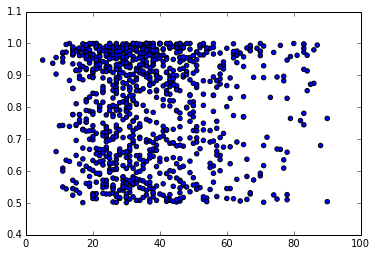

In [113]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import random

exps, lens = zip(*random.sample(filter(lambda r : r[0] > 0.5, rows), 1000))
plt.scatter(lens, exps)

## Debugging pipeline

We'll debug here, also to show the general most current procedure for debugging treedlib on examples in a SQL database (e.g. from DeepDive)

In [ ]:
%sql postgresql://ajratner@localhost:5432/deepdive_spouse

In [ ]:
%%sql 
SELECT sentence_text
FROM sentences 
WHERE doc_id = '79205745-b593-4b98-8a94-da6b8238fefc' AND sentence_index = 32;

In [ ]:
res = %sql SELECT tokens AS "words", lemmas, pos_tags, ner_tags, dep_types AS "dep_labels", dep_tokens AS "dep_parents" FROM sentences WHERE doc_id = '79205745-b593-4b98-8a94-da6b8238fefc' AND sentence_index = 32;
xts = map(corenlp_to_xmltree, res)

In [ ]:
xt = xts[0]
xt.render_tree(highlight=[[21,22], [33,34]])

In [ ]:
print_gen(get_relation_features(xt.root, [21,22], [33,34]))

## Feature focus: Preceding statements which nullify or negate meaning

Example:
> _Ex1:_ To investigate whether mutations in the SURF1 gene are a cause of Charcot-Marie-Tooth -LRB- CMT -RRB- disease

> _Ex2:_ To investigate the genetic effect of a new mutation found in exon 17 of the myophosphorylase -LRB- PYGM -RRB- gene as a cause of McArdle disease -LRB- also known as type 5 glycogenosis -RRB-.

Notes:
* These seem to mostly be **_modifiers of the primary verb_**?
    * We are only sampling from a limited set of patterns of sentences (due to narrow DSR set) currently...
* Modifiers in general...?
* _I know how RNNs claim to / do handle this phenomenon..._ *

In [ ]:
ex1_id = ('24027061', 'Abstract.0', 1)
ex1_raw="""
<node dep_parent="0" lemma="investigate" ner="O" pos="VB" word="investigate" word_idx="1"><node dep_parent="2" dep_path="aux" lemma="to" ner="O" pos="TO" word="To" word_idx="0"/><node dep_parent="2" dep_path="ccomp" lemma="cause" ner="O" pos="NN" word="cause" word_idx="10"><node dep_parent="11" dep_path="mark" lemma="whether" ner="O" pos="IN" word="whether" word_idx="2"/><node dep_parent="11" dep_path="nsubj" lemma="mutation" ner="O" pos="NNS" word="mutations" word_idx="3"><node dep_parent="4" dep_path="prep_in" lemma="gene" ner="O" pos="NN" word="gene" word_idx="7"><node dep_parent="8" dep_path="det" lemma="the" ner="O" pos="DT" word="the" word_idx="5"/><node dep_parent="8" dep_path="nn" lemma="surf1" ner="O" pos="NN" word="SURF1" word_idx="6"/></node></node><node dep_parent="11" dep_path="cop" lemma="be" ner="O" pos="VBP" word="are" word_idx="8"/><node dep_parent="11" dep_path="det" lemma="a" ner="O" pos="DT" word="a" word_idx="9"/><node dep_parent="11" dep_path="prep_of" lemma="Charcot-Marie-Tooth" ner="O" pos="NNP" word="Charcot-Marie-Tooth" word_idx="12"/><node dep_parent="11" dep_path="dep" lemma="disease" ner="O" pos="NN" word="disease" word_idx="16"><node dep_parent="17" dep_path="appos" lemma="CMT" ner="O" pos="NNP" word="CMT" word_idx="14"/></node></node></node>
"""
xt1 = XMLTree(et.fromstring(ex1_raw))
ex2_id = ('15262743', 'Abstract.0', 1)
ex2_raw="""
<node dep_parent="0" lemma="investigate" ner="O" pos="VB" word="investigate" word_idx="1"><node dep_parent="2" dep_path="aux" lemma="to" ner="O" pos="TO" word="To" word_idx="0"/><node dep_parent="2" dep_path="dobj" lemma="effect" ner="O" pos="NN" word="effect" word_idx="4"><node dep_parent="5" dep_path="det" lemma="the" ner="O" pos="DT" word="the" word_idx="2"/><node dep_parent="5" dep_path="amod" lemma="genetic" ner="O" pos="JJ" word="genetic" word_idx="3"/><node dep_parent="5" dep_path="prep_of" lemma="mutation" ner="O" pos="NN" word="mutation" word_idx="8"><node dep_parent="9" dep_path="det" lemma="a" ner="O" pos="DT" word="a" word_idx="6"/><node dep_parent="9" dep_path="amod" lemma="new" ner="O" pos="JJ" word="new" word_idx="7"/><node dep_parent="9" dep_path="vmod" lemma="find" ner="O" pos="VBN" word="found" word_idx="9"><node dep_parent="10" dep_path="prep_in" lemma="exon" ner="O" pos="NN" word="exon" word_idx="11"><node dep_parent="12" dep_path="num" lemma="17" ner="NUMBER" pos="CD" word="17" word_idx="12"/><node dep_parent="12" dep_path="prep_of" lemma="gene" ner="O" pos="NN" word="gene" word_idx="19"><node dep_parent="20" dep_path="det" lemma="the" ner="O" pos="DT" word="the" word_idx="14"/><node dep_parent="20" dep_path="nn" lemma="myophosphorylase" ner="O" pos="NN" word="myophosphorylase" word_idx="15"/><node dep_parent="20" dep_path="nn" lemma="pygm" ner="O" pos="NN" word="PYGM" word_idx="17"/></node></node><node dep_parent="10" dep_path="prep_as" lemma="cause" ner="O" pos="NN" word="cause" word_idx="22"><node dep_parent="23" dep_path="det" lemma="a" ner="O" pos="DT" word="a" word_idx="21"/><node dep_parent="23" dep_path="prep_of" lemma="disease" ner="O" pos="NN" word="disease" word_idx="25"><node dep_parent="26" dep_path="nn" lemma="McArdle" ner="PERSON" pos="NNP" word="McArdle" word_idx="24"/><node dep_parent="26" dep_path="vmod" lemma="know" ner="O" pos="VBN" word="known" word_idx="28"><node dep_parent="29" dep_path="advmod" lemma="also" ner="O" pos="RB" word="also" word_idx="27"/><node dep_parent="29" dep_path="prep_as" lemma="glycogenosis" ner="O" pos="NN" word="glycogenosis" word_idx="32"><node dep_parent="33" dep_path="nn" lemma="type" ner="O" pos="NN" word="type" word_idx="30"/><node dep_parent="33" dep_path="num" lemma="5" ner="NUMBER" pos="CD" word="5" word_idx="31"/></node></node></node></node></node></node></node></node>
"""
xt2 = XMLTree(et.fromstring(ex2_raw))

In [ ]:
xt1.render_tree()
xt2.render_tree()

### Testing XML speeds

How does it compare between:
* parse to XML via this python code, store as string, then parse from string at runtime
* just parse to XML at runtime via this python code?

In [ ]:
# Map sentence to xmltree
%time xts = map(corenlp_to_xmltree, rows)

In [ ]:
# Pre-process to xml string
xmls = [xt.to_str() for xt in map(corenlp_to_xmltree, rows)]

# Parse @ runtime using lxml
%time roots = map(et.fromstring, xmls)

### Table example

In [ ]:
# Some wishful thinking...
table_xml = """
<div class="table-wrapper">
    <h3>Causal genomic relationships</h3>
    <table>
        <tr><th>Gene</th><th>Variant</th><th>Phenotype</th></tr>
        <tr><td>ABC</td><td><i>AG34</i></td><td>Headaches during defecation</td></tr>
        <tr><td>BDF</td><td><i>CT2</i></td><td>Defecation during headaches</td></tr>
        <tr><td>XYG</td><td><i>AT456</i></td><td>Defecasomnia</td></tr>
    </table>
</div>
"""
from IPython.core.display import display_html, HTML
display_html(HTML(table_xml))